In [18]:
import argparse
import os, sys
import time
import datetime
import matplotlib.pyplot as plt

# Import pytorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm

# You cannot change this line.
from tools.dataloader import CIFAR10,CIFAR10_test
#from tools.dataloader import CIFAR10_test

In [19]:
# Create the neural network module:
class MyDNN(nn.Module):
    def __init__(self):
        super(MyDNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.conv2 = nn.Conv2d(16, 16, 3, 1, 1)
        self.conv3 = nn.Conv2d(16, 16, 3, 1, 1)
        self.conv4 = nn.Conv2d(16, 16, 3, 1, 1)
        self.conv5 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv6 = nn.Conv2d(32, 32, 3, 1, 1)
        self.conv7 = nn.Conv2d(32, 32, 3, 1, 1)
        self.conv8 = nn.Conv2d(32, 32, 3, 1, 1)
        self.conv9 = nn.Conv2d(32, 32, 3, 1, 1)
        self.conv10 = nn.Conv2d(32, 32, 3, 1, 1)
        self.conv11 = nn.Conv2d(16, 32, 1)
        self.bn1 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.9)
        self.bn2 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.9)
        self.bn3 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.9)
        self.bn4 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.9)
        self.bn5 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.9)
        self.bn6 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.9)
        self.bn7 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.9)
        self.bn8 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.9)
        self.bn9 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.9)
        self.bn10 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.9)
        self.fc1 = nn.Linear(32*16*16, 1000)
        self.fc2 = nn.Linear(1000, 10)
        
    def forward(self, x):
        output1 = F.relu(self.bn1(self.conv1(x)))
        output1 = F.relu(self.bn2(self.conv2(output1)))
        
        output2 = F.relu(self.bn3(self.conv3(output1)))
        output2 = F.relu(self.bn4(output1 + self.conv4(output2)))
        
        output3 = F.relu(self.bn5(self.conv5(output2)))
        output3 = F.relu(self.bn6(self.conv11(output2) + self.conv6(output3)))
        
        output4 = F.relu(self.bn7(self.conv7(output3)))
        output4 = F.relu(self.bn8(output3 + self.conv8(output4)))
        
        output5 = F.relu(self.bn9(self.conv9(output4)))
        output5 = F.relu(self.bn10(output4 + self.conv10(output5)))
        
        output = F.avg_pool2d(output5,2)
        output = output.view(output.size(0), -1)
        output = F.relu(self.fc1(output))
        output = self.fc2(output)
        return output

In [20]:
# Setting some hyperparameters
TRAIN_BATCH_SIZE = 256
VAL_BATCH_SIZE = 100
INITIAL_LR = 0.01
MOMENTUM = 0.9
REG = 1e-5
EPOCHS = 100
DATAROOT = "./data"
CHECKPOINT_PATH = "./saved_model"

**Your answer:**

In [21]:
# Specify preprocessing function.
# Reference mean/std value for 
transform_train = transforms.Compose([
    transforms.RandomCrop(32, 4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

**Your answer:**

In [22]:
# Call the dataset Loader
trainset = CIFAR10(root=DATAROOT, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=1)
valset = CIFAR10(root=DATAROOT, train=False, download=True, transform=transform_val)
valloader = torch.utils.data.DataLoader(valset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=1)
testset = CIFAR10_test(root=DATAROOT, train=False, download=True, transform=transform_val)
testloader = torch.utils.data.DataLoader(testset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=1)

Using downloaded and verified file: ./data/cifar10_trainval.tar.gz
Extracting ./data/cifar10_trainval.tar.gz to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval.tar.gz
Extracting ./data/cifar10_trainval.tar.gz to ./data
Files already downloaded and verified


In [23]:
# Specify the device for computation
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = MyDNN()
net = net.to(device)
if device =='cuda':
    print("Train on GPU...")
else:
    print("Train on CPU...")

Train on GPU...


In [24]:
# FLAG for loading the pretrained model
TRAIN_FROM_SCRATCH = False
# Code for loading checkpoint and recover epoch id.
CKPT_PATH = "./saved_model/model.h5"
def get_checkpoint(ckpt_path):
    try:
        ckpt = torch.load(ckpt_path)
    except Exception as e:
        print(e)
        return None
    return ckpt

ckpt = get_checkpoint(CKPT_PATH)
if ckpt is None or TRAIN_FROM_SCRATCH:
    if not TRAIN_FROM_SCRATCH:
        print("Checkpoint not found.")
    print("Training from scratch ...")
    start_epoch = 0
    current_learning_rate = INITIAL_LR
else:
    print("Successfully loaded checkpoint: %s" %CKPT_PATH)
    net.load_state_dict(ckpt['net'])
    start_epoch = ckpt['epoch'] + 1
    current_learning_rate = ckpt['lr']
    print("Starting from epoch %d " %start_epoch)

print("Starting from learning rate %f:" %current_learning_rate)

[Errno 2] No such file or directory: './saved_model/model.h5'
Checkpoint not found.
Training from scratch ...
Starting from learning rate 0.010000:


In [25]:
# Create loss function and specify regularization
criterion = nn.CrossEntropyLoss()
# Add optimizer
optimizer = optim.SGD(net.parameters(), INITIAL_LR, MOMENTUM, REG)

2019-10-02 00:47:40.040962
Epoch 0:
176
Initial loss: 2.3203
Training loss: 1.7327, Training accuracy: 0.4167
2019-10-02 00:47:52.035882
Validation...
Validation loss: 1.2706, Validation accuracy: 0.5418
Saving ...
2019-10-02 00:47:53.346318
Epoch 1:
176
Training loss: 1.2502, Training accuracy: 0.5602
2019-10-02 00:48:05.754204
Validation...
Validation loss: 1.0536, Validation accuracy: 0.6212
Saving ...
2019-10-02 00:48:07.062544
Epoch 2:
176
Training loss: 1.0337, Training accuracy: 0.6357
2019-10-02 00:48:19.206401
Validation...
Validation loss: 0.9076, Validation accuracy: 0.6756
Saving ...
2019-10-02 00:48:20.535266
Epoch 3:
176
Training loss: 0.9005, Training accuracy: 0.6784
2019-10-02 00:48:32.637473
Validation...
Validation loss: 0.8557, Validation accuracy: 0.6990
Current learning rate has decayed to 0.100000
Saving ...
2019-10-02 00:48:33.933923
Epoch 4:
176
Training loss: 1.3401, Training accuracy: 0.5676
2019-10-02 00:48:45.998281
Validation...
Validation loss: 0.9602, Va

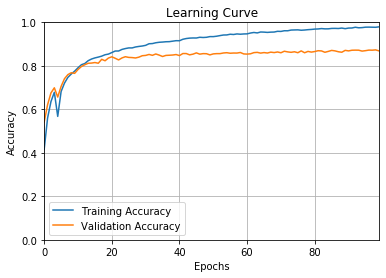

In [26]:
# Start the training/validation process
# The process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
global_step = 0
best_val_acc = 0
training_accuracies = []
validation_accuracies = []
my_flag = 0

for i in range(start_epoch, EPOCHS):
    print(datetime.datetime.now())
    # Switch to train mode
    net.train()
    print("Epoch %d:" %i)

    total_examples = 0
    correct_examples = 0

    train_loss = 0
    train_acc = 0
    # Train the training dataset for 1 epoch.
    print(len(trainloader))
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # Copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Zero the gradient
        optimizer.zero_grad()
        # Generate output
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        if my_flag == 0:
            print("Initial loss: %.4f" %(loss))
            my_flag = 1
        # Now backward loss
        loss.backward()
        # Apply gradient
        optimizer.step()
        # Calculate predicted labels
        _, predicted = outputs.max(1)
        # Calculate accuracy
        total_examples += len(outputs)
        correct_examples += predicted.eq(targets).sum().item()

        train_loss += loss

        global_step += 1
        if global_step % 100 == 0:
            avg_loss = train_loss / (batch_idx + 1)
        pass
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
    training_accuracies.append(avg_acc)
    print(datetime.datetime.now())
    # Validate on the validation dataset
    print("Validation...")
    total_examples = 0
    correct_examples = 0
    
    net.eval()

    val_loss = 0
    val_acc = 0
    # Disable gradient during validation
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            # Copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Zero the gradient
            optimizer.zero_grad()
            # Generate output from the DNN.
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            # Calculate predicted labels
            _, predicted = outputs.max(1)
            # Calculate accuracy
            total_examples += len(outputs)
            correct_examples += predicted.eq(targets).sum().item()
            val_loss += loss

    avg_loss = val_loss / len(valloader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    validation_accuracies.append(avg_acc)
    
    DECAY_EPOCHS = 10
    DECAY = 0.9
    
    if i == 3:
        current_learning_rate = 0.1
        for param_group in optimizer.param_groups:
            # Assign the learning rate parameter
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)
        
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate*DECAY
        for param_group in optimizer.param_groups:
            # Assign the learning rate parameter
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)
    
    # Save for checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_PATH):
            os.makedirs(CHECKPOINT_PATH)
        print("Saving ...")
        state = {'net': net.state_dict(),
                 'epoch': i,
                 'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_PATH, 'model.h5'))

print("Optimization finished.")
all_epochs = list(range(EPOCHS))
plt.plot(all_epochs, training_accuracies, label = 'Training Accuracy')
plt.plot(all_epochs, validation_accuracies, label = 'Validation Accuracy')
plt.ylim(0,1)
plt.xlim(0,EPOCHS-1)
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [28]:
import numpy as np
print(len(testloader))
predicted_labels = np.array([])
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
        # Copy inputs to device
        inputs = inputs.to(device)
        # Zero the gradient
        optimizer.zero_grad()
        # Generate output from the DNN.
        outputs = net(inputs)
        # Calculate predicted labels
        _, predicted = outputs.max(1)
        predicted_labels = np.append(predicted_labels, predicted.data.cpu().numpy())

100


In [29]:
predicted_labels = np.append(range(10000), predicted_labels)
predicted_labels = np.reshape(predicted_labels, (2,-1)).transpose()
print(predicted_labels)

np.savetxt('labels.csv', predicted_labels, delimiter=',', fmt=['%d', '%d'], header='id,Category') 

[[0.000e+00 1.000e+00]
 [1.000e+00 0.000e+00]
 [2.000e+00 2.000e+00]
 ...
 [9.997e+03 4.000e+00]
 [9.998e+03 7.000e+00]
 [9.999e+03 3.000e+00]]
